In [84]:
#Imports
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import copy
import pfr
import time
from sklearn.grid_search import GridSearchCV

In [2]:
# reupload all data to have as one dataset again
completedf1 = pd.concat([pd.read_csv('0204plays.csv'),pd.read_csv('0507plays.csv'),pd.read_csv('0810plays.csv'),pd.read_csv('1114plays.csv')])

#(remove 2002, because it has served it's purpose of creating 2003 priors)
completedf = completedf1[completedf1['year']>2002].reset_index(drop=True)

# define number of plays in df, which is now our finalized dataset with all variables
plays = len(completedf)

/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (63,102) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [3]:
print completedf.shape
completedf.head(2)

lcols = ["distToGoal","inDown3","inDown2","inDown1","inQuarter4","inQuarter3","inQuarter2","inQuarter1","secsElapsedInHalf","margin","yds_to_go","addscore","tm_TO_left","opp_TO_left","inFGRange", "inRedZone", "tm_winprob","inLast3minHalf", "tm_prev_yr_pass","tm_in_season_pass","tm_in_game_pass","StartofDrive","prevWasPass"]

(397349, 139)


In [4]:
def masking(df,itrain,itest):    
    mask=np.ones(df.shape[0], dtype='int')
    mask[itrain]=1
    mask[itest]=0
    mask = (mask==1)
    return mask

In [6]:
def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

In [7]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.6f" % (training_accuracy)
    print "Accuracy on test data:     %0.6f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest, test_accuracy

In [198]:
def runsvm2(df,lcols,mask,Cs):    
    from sklearn.svm import LinearSVC
    clfsvm_lin=LinearSVC(loss="hinge")
    parameters = {"C": Cs}
    # could add njobs to the mix to run them in parallel
    clfsvm_lin, Xtrainlin, ytrainlin, Xtestlin, ytestlin,_ = do_classify(clfsvm_lin, parameters, df, lcols, u'RESP', 1, mask=mask)
    return clfsvm_lin, Xtrainlin, ytrainlin, Xtestlin, ytestlin,_

def runsvc2(df,lcols,mask,Cs):    
    from sklearn.svm import SVC
    clfsvm_orig = SVC()
    parameters = {"C": Cs}
    # could add njobs to the mix to run them in parallel
    clfsvm_orig, Xtrainorig, ytrainorig, Xtestorig, ytestorig,_ = do_classify(clfsvm_orig, parameters, df, lcols, u'RESP', 1, mask=mask)
    return clfsvm_orig, Xtrainorig, ytrainorig, Xtestorig, ytestorig,_

def randforest(df,lcols,mask):    
    from sklearn.ensemble import RandomForestClassifier
    clfForest = RandomForestClassifier()
    parameters = {"n_estimators": np.arange(1,100,5)}
    # could add njobs to the mix to run them in parallel
    clfForest, Xtrainrf, ytrainrf, Xtestrf, ytestrf,_ = do_classify(clfForest, parameters, df, lcols, u'RESP', 1, mask=mask, score_func='f1')
    return clfForest, Xtrainrf, ytrainrf, Xtestrf, ytestrf,_

def gradboost(df,lcols,mask):
    from sklearn.ensemble import GradientBoostingClassifier
    clfGB = GradientBoostingClassifier()
    parameters = {"max_depth": range(1, 8)}
    clfGB, Xtraingb, ytraingb, Xtestgb, ytestgb,_ = do_classify(clfGB, parameters, df, lcols, u'RESP', 1, mask=mask, score_func='f1')
    return clfGB, Xtraingb, ytraingb, Xtestgb, ytestgb,_

def adaboost(clfForest,df,lcols,mask):
    from sklearn.ensemble import AdaBoostClassifier
    clfAda = AdaBoostClassifier(base_estimator=clfForest)
    parameters = {"n_estimators": np.arange(1, 100, 5)}
    clfAda, Xtrainada, ytrainada, Xtestada, ytestada,_ = do_classify(clfAda, parameters, df, lcols, u'RESP', 1, mask=mask, score_func='f1')
    return clfAda, Xtrainada, ytrainada, Xtestada, ytestada,_

In [188]:
def plot_features(clfForest,lcols,name):
    importance_list = clfForest.feature_importances_
    importance_list, name_list = zip(*sorted(zip(importance_list, lcols)))
    width = 0.8
    yTickPos = np.arange(len(importance_list))
    yBarPos = yTickPos - (width/2.0)
    plt.barh(yBarPos,importance_list,align='center', color="lightskyblue")
    plt.yticks(yTickPos, name_list)
    plt.ylim((min(yTickPos)-0.6, max(yTickPos)+0.6))
    plt.grid(False)
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.title('Relative Importance of Each Feature for %s' % str(name))
    plt.show()
    

def plot_decision_surface(clf, X_train, Y_train):
    plot_step=0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=plt.cm.Paired, alpha=0.40, s=20)
    plt.show()
    
    print type(X_train[:, 0].min()), type(plot_step)
    

def plot_rf(clfForest,label,lcols,df):
    xt = [lcols[e] for e in clfForest.feature_importances_.argsort()[::-1][0:2]]
    X_imp = df[xt].values
    Y = df.RESP.values
    plt.title(label)
    plt.xlabel(xt[0])
    plt.ylabel(xt[1])
    plt.grid(False)
    plot_decision_surface(clfForest, X_imp, Y)

In [163]:
year = 2014 # whatever year you want to test
df = completedf[completedf['year']==year]

In [164]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.7)
mask = masking(df,itrain,itest)
Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0] # try fewer if doesnt finish up

In [135]:
# run linear svm model
clfsvm_lin, Xtrainlin, ytrainlin, Xtestlin, ytestlin,_ = runsvm2(df, lcols, mask, Cs)

using mask
BEST {'C': 10.0} 0.592454304693 [mean: 0.58021, std: 0.05725, params: {'C': 0.001}, mean: 0.56940, std: 0.03029, params: {'C': 0.01}, mean: 0.56089, std: 0.05659, params: {'C': 0.1}, mean: 0.53996, std: 0.06361, params: {'C': 1.0}, mean: 0.59245, std: 0.04800, params: {'C': 10.0}, mean: 0.56341, std: 0.05565, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.550818
Accuracy on test data:     0.544976
[[3840  308]
 [4184 1540]]
########################################################


/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [18]:
# run svc model
clfsvm_orig, Xtrainorig, ytrainorig, Xtestorig, ytestorig,_ = runsvc2(df, lcols, mask, Cs)

using mask
BEST {'C': 0.001} 0.575286523515 [mean: 0.57529, std: 0.00005, params: {'C': 0.001}, mean: 0.57529, std: 0.00005, params: {'C': 0.01}, mean: 0.57529, std: 0.00005, params: {'C': 0.1}, mean: 0.57458, std: 0.00205, params: {'C': 1.0}, mean: 0.57265, std: 0.00289, params: {'C': 10.0}, mean: 0.57292, std: 0.00291, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.575287
Accuracy on test data:     0.577664
[[   0 4122]
 [   0 5638]]
########################################################


/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [173]:
# run logistic regression with lasso model
from sklearn.linear_model import LogisticRegression
clflog, Xtrain1, ytrain1, Xtest1, ytest1,_ = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df, lcols, u'RESP', 1, mask=mask)

using mask
BEST {'C': 100} 0.669978438253 [mean: 0.59726, std: 0.01171, params: {'C': 0.001}, mean: 0.66089, std: 0.01236, params: {'C': 0.01}, mean: 0.66905, std: 0.01109, params: {'C': 0.1}, mean: 0.66985, std: 0.01012, params: {'C': 1}, mean: 0.66964, std: 0.01014, params: {'C': 10}, mean: 0.66998, std: 0.00988, params: {'C': 100}]
############# based on standard predict ################
Accuracy on training data: 0.671035
Accuracy on test data:     0.668442
[[2067 1982]
 [1379 4709]]
########################################################


/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [174]:
# run logistic model 2
clflog2, Xtrain2, ytrain2, Xtest2, ytest2,_ = do_classify(LogisticRegression(penalty="l2"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df, lcols, u'RESP', 1, mask=mask)

using mask
BEST {'C': 10} 0.670316661734 [mean: 0.65400, std: 0.00742, params: {'C': 0.001}, mean: 0.66710, std: 0.01168, params: {'C': 0.01}, mean: 0.66943, std: 0.00885, params: {'C': 0.1}, mean: 0.66947, std: 0.00948, params: {'C': 1}, mean: 0.67032, std: 0.01049, params: {'C': 10}, mean: 0.66901, std: 0.00989, params: {'C': 100}]
############# based on standard predict ################
Accuracy on training data: 0.671035
Accuracy on test data:     0.668146
[[2067 1982]
 [1382 4706]]
########################################################


/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [186]:
#Random forest classifier
clfForest, Xtrainrf, ytrainrf, Xtestrf, ytestrf,_ = randforest(df,lcols,mask)

using mask
BEST {'n_estimators': 91} 0.750209219276 [mean: 0.67519, std: 0.00567, params: {'n_estimators': 1}, mean: 0.69136, std: 0.00856, params: {'n_estimators': 6}, mean: 0.73258, std: 0.00381, params: {'n_estimators': 11}, mean: 0.72633, std: 0.00737, params: {'n_estimators': 16}, mean: 0.74233, std: 0.00339, params: {'n_estimators': 21}, mean: 0.73561, std: 0.00184, params: {'n_estimators': 26}, mean: 0.74540, std: 0.00210, params: {'n_estimators': 31}, mean: 0.73969, std: 0.00419, params: {'n_estimators': 36}, mean: 0.74759, std: 0.00291, params: {'n_estimators': 41}, mean: 0.74303, std: 0.00502, params: {'n_estimators': 46}, mean: 0.74674, std: 0.00400, params: {'n_estimators': 51}, mean: 0.74419, std: 0.00527, params: {'n_estimators': 56}, mean: 0.74711, std: 0.00535, params: {'n_estimators': 61}, mean: 0.74637, std: 0.00418, params: {'n_estimators': 66}, mean: 0.74572, std: 0.00524, params: {'n_estimators': 71}, mean: 0.74766, std: 0.00581, params: {'n_estimators': 76}, mean:

/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


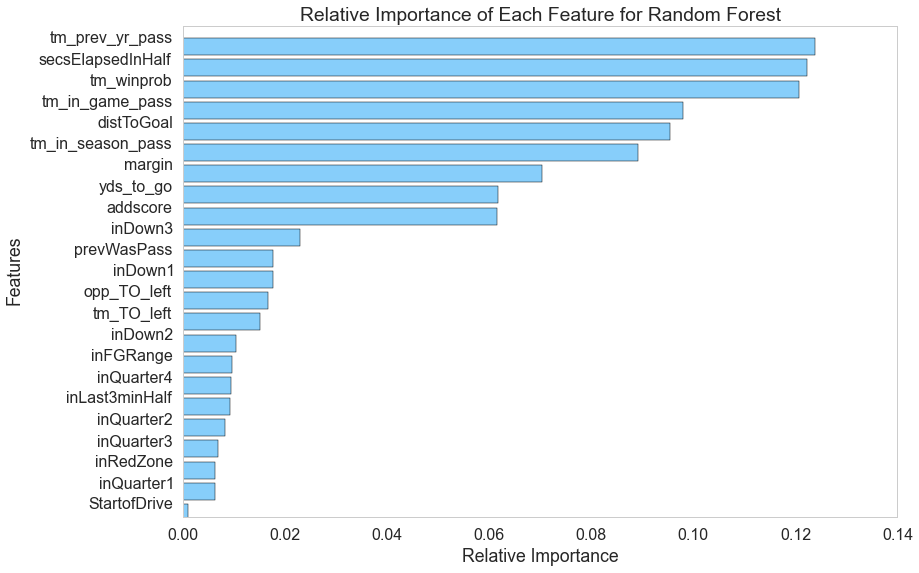

In [187]:
# make random forest plots
plot_features(clfForest,lcols,"Random Forest")

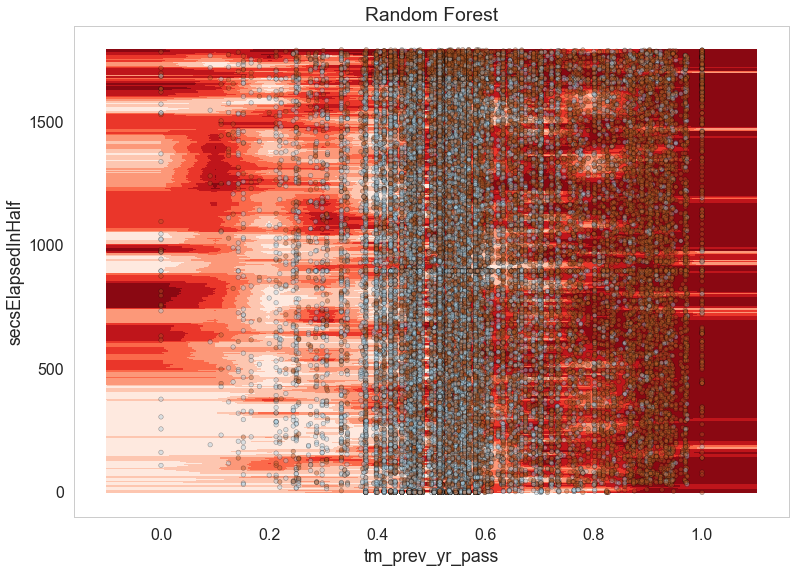

<type 'numpy.float64'> <type 'float'>


In [189]:
# make random forest plots
plot_rf(clfForest,"Random Forest",lcols,df)

In [24]:
# ADA Boost Classifier
clfAda, Xtrainada, ytrainada, Xtestada, ytestada,_ = adaboost(clfForest,df,lcols,mask) 

using mask
BEST {'n_estimators': 3} 0.723314593572 [mean: 0.71552, std: 0.01456, params: {'n_estimators': 1}, mean: 0.71736, std: 0.01574, params: {'n_estimators': 2}, mean: 0.72331, std: 0.01808, params: {'n_estimators': 3}, mean: 0.72019, std: 0.01782, params: {'n_estimators': 4}, mean: 0.72160, std: 0.01531, params: {'n_estimators': 5}, mean: 0.72006, std: 0.01763, params: {'n_estimators': 6}, mean: 0.72187, std: 0.01444, params: {'n_estimators': 7}, mean: 0.72254, std: 0.01765, params: {'n_estimators': 8}, mean: 0.72214, std: 0.01502, params: {'n_estimators': 9}, mean: 0.72148, std: 0.01374, params: {'n_estimators': 10}, mean: 0.72099, std: 0.01438, params: {'n_estimators': 11}, mean: 0.72174, std: 0.01543, params: {'n_estimators': 12}, mean: 0.72070, std: 0.01337, params: {'n_estimators': 13}, mean: 0.72143, std: 0.01448, params: {'n_estimators': 14}, mean: 0.72180, std: 0.01295, params: {'n_estimators': 15}, mean: 0.72130, std: 0.01449, params: {'n_estimators': 16}, mean: 0.72111

/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


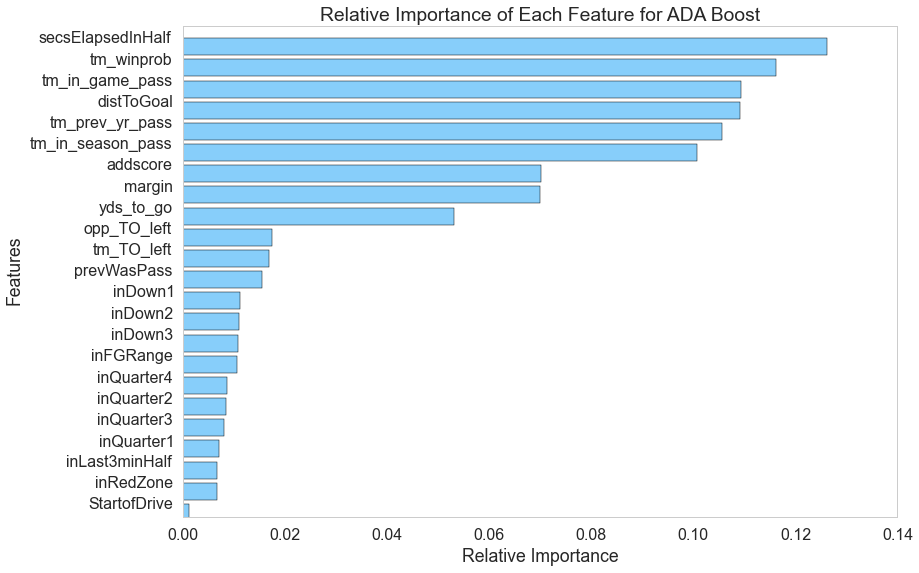

In [191]:
# make ada boost features plots
plot_features(clfAda,lcols,"ADA Boost")

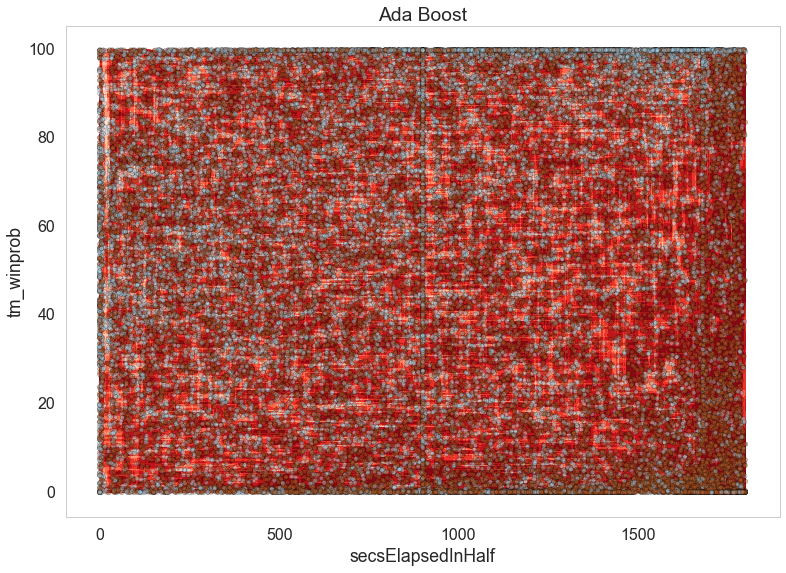

<type 'numpy.float64'> <type 'float'>


In [192]:
# make ada boost plots
plot_rf(clfAda,"Ada Boost",lcols,df)

In [176]:
# Gradient Boost CLassifier
clfGB, Xtraingb, ytraingb, Xtestgb, ytestgb,_ = gradboost(df,lcols,mask)

using mask
BEST {'max_depth': 5} 0.754437980904 [mean: 0.74326, std: 0.00652, params: {'max_depth': 1}, mean: 0.74897, std: 0.00538, params: {'max_depth': 2}, mean: 0.74946, std: 0.00642, params: {'max_depth': 3}, mean: 0.75323, std: 0.00391, params: {'max_depth': 4}, mean: 0.75444, std: 0.00427, params: {'max_depth': 5}, mean: 0.74897, std: 0.00373, params: {'max_depth': 6}, mean: 0.74464, std: 0.00326, params: {'max_depth': 7}]
############# based on standard predict ################
Accuracy on training data: 0.753477
Accuracy on test data:     0.704153
[[2533 1516]
 [1483 4605]]
########################################################


/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


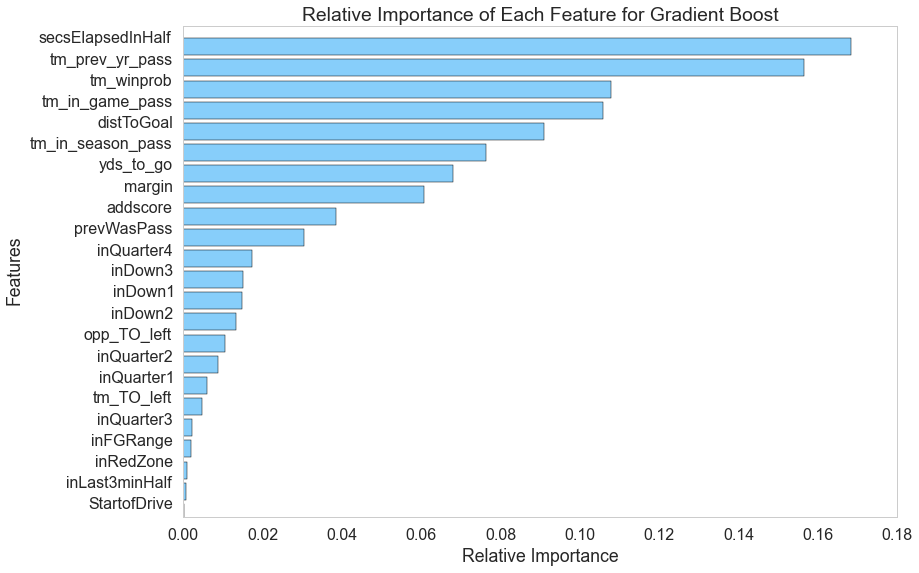

In [185]:
# make gradient boost features plots
plot_features(clfGB,lcols,"Gradient Boost")

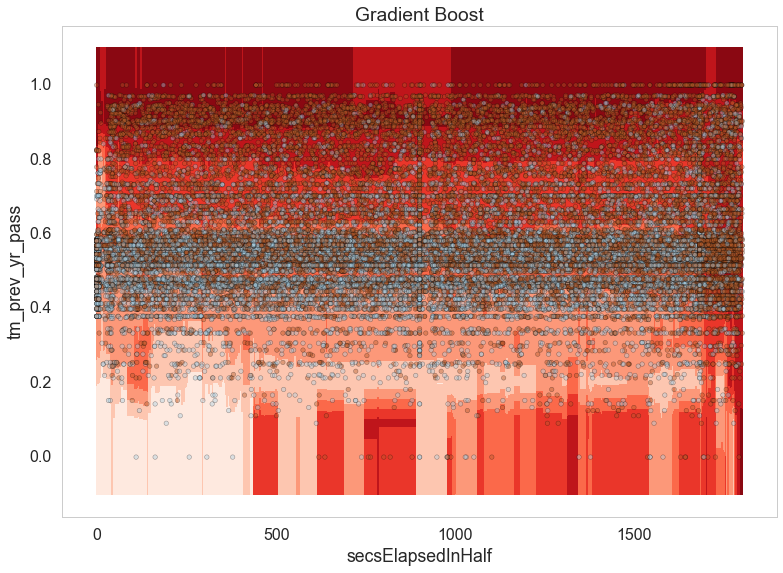

<type 'numpy.float64'> <type 'float'>


In [190]:
# make gradient boost plots
plot_rf(clfGB,"Gradient Boost",lcols,df)

In [159]:
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
        ax.grid(False)
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
    ax.legend(loc="lower right")
    return ax

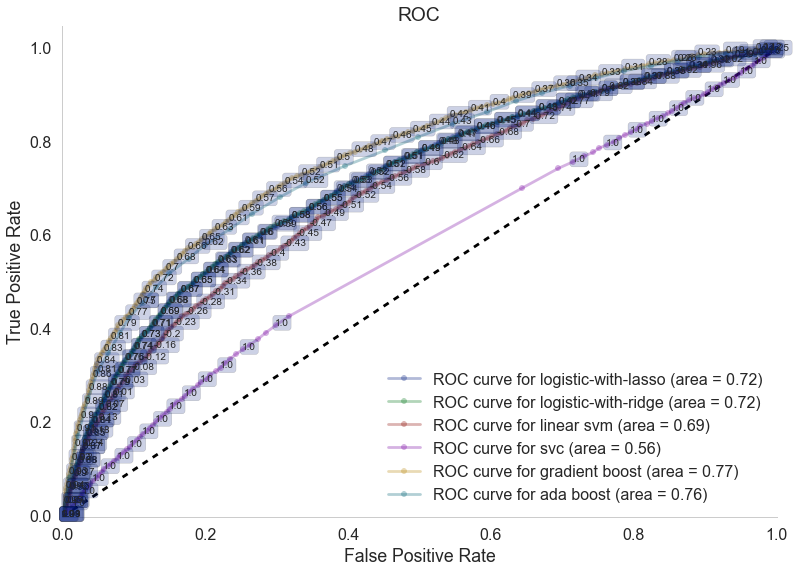

In [175]:
with sns.color_palette("dark"):
    ax=make_roc("logistic-with-lasso",clflog, ytest1, Xtest1, labe=200, proba=True, skip=50)
    make_roc("logistic-with-ridge",clflog2, ytest2, Xtest2, ax, labe=200, proba=True, skip=50);
    make_roc("linear svm",clfsvm_lin, ytestlin, Xtestlin, ax, labe=200, proba=False, skip=50);
    make_roc("svc",clfsvm_orig, ytestorig, Xtestorig, ax, labe=200, proba=False, skip=50);
    make_roc("gradient boost",clfGB, ytestgb, Xtestgb, ax, labe=200, proba=True, skip=50);
    make_roc("ada boost",clfAda, ytestada, Xtestada, ax, labe=200, proba=True, skip=50);

In [197]:
# Compile progression of quick classifier's performance
years = np.arange(2003,2015)
svm_ = []
log_lasso = []
log_ridge = []
rf = []
gb = []
for yr in years:
    dfp = completedf[completedf['year']==year]
    _, _, _, _, _,svm_acc = runsvm2(dfp, lcols, mask, Cs)
    _, _, _, _, _,log_lasso_acc = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df, lcols, u'RESP', 1, mask=mask)
    _, _, _, _, _,log_ridge_acc = do_classify(LogisticRegression(penalty="l2"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df, lcols, u'RESP', 1, mask=mask)
    _, _, _, _, _,rf_acc = randforest(df,lcols,mask)
    _, _, _, _, _,gb_acc = gradboost(df,lcols,mask)
    svm_.append(svm_acc)
    log_lasso.append(log_lasso_acc)
    log_ridge.append(log_ridge)
    rf.append(rf_acc)
    gb.append(gb_acc)
performance = [svm_,log_lasso,log_ridge,rf,gb]

2003


In [ ]:
# Display progression
N = len(performance)
labels = ["svm", "logistic-lasso", "logistic-ridge", "random forest", "gradient boost"]
for i in range(N):
    plt.plot(years, i, label = labels[i], lw=1, ls = "-")
plt.grid(False)
plt.xlabel("Years")
plt.ylabel("Classifier accuracy on test set")
plt.title("Progression of Classifier Accuracy")
plt.legend(loc="best")